In [1]:
import pandas as pd

# Obtener parejas y reportes

In [2]:
df_report_pairs = pd.read_pickle('data/raw_report_pairs.pkl')
df_reports = pd.read_pickle('data/raw_reports.pkl')

In [3]:
df_report_pairs.sample(3)

,type,id_M,id_D,statusM,statusD,componentM,componentD,summaryM,summaryD,commentsM,commentsD,text1M,text1D,text2M,text2D,text3M,text3D,text4M,text4D
4885,master,1731050,1785265,RESOLVED,RESOLVED,Session Restore,Theme,"Hidden tabs are listed in ""Recent tabs""","[Colorway Closet] Set role=""presentation"" on c...",User Agent: Mozilla/5.0 (X11; Ubuntu; Linux x8...,Feedback from a11y on the new assets:\n> [...]...,"Hidden tabs are listed in ""Recent tabs""","[Colorway Closet] Set role=""presentation"" on c...","Hidden tabs are listed in ""Recent tabs"" Sessio...","[Colorway Closet] Set role=""presentation"" on c...","Hidden tabs are listed in ""Recent tabs""","[Colorway Closet] Set role=""presentation"" on c...","Hidden tabs are listed in ""Recent tabs"" Sessio...","[Colorway Closet] Set role=""presentation"" on c..."
1916,master,1680732,1610037,RESOLVED,NEW,Bookmarks & History,Address Bar,Bookmark items displayed are inconsistent when...,Bookmark and tab symbols are not visible enough,Reproducible: always when a lot of bookmarks i...,"Long-time user here, did some thorough testing...",Bookmark items displayed are inconsistent when...,Bookmark and tab symbols are not visible enough,Bookmark items displayed are inconsistent when...,Bookmark and tab symbols are not visible enoug...,Bookmark items displayed are inconsistent when...,Bookmark and tab symbols are not visible enoug...,Bookmark items displayed are inconsistent when...,Bookmark and tab symbols are not visible enoug...
2970,master,1661803,1688939,RESOLVED,RESOLVED,Pioneer,Address Bar,Check for presence of default add-on before un...,Create technical documentation for Adm quicksu...,The required telemetry probe noting the timest...,,Check for presence of default add-on before un...,Create technical documentation for Adm quicksu...,Check for presence of default add-on before un...,Create technical documentation for Adm quicksu...,Check for presence of default add-on before un...,Create technical documentation for Adm quicksu...,Check for presence of default add-on before un...,Create technical documentation for Adm quicksu...


In [4]:
df_reports.sample(3)

,report_id,creation_time,status,component,dupe_of,summary,comments,text1,text2,text3,text4
7262,1754227,2022-02-08 16:51:40,RESOLVED,Messaging System,1744293.0,Update PBM template to support Firefox Focus p...,Scope of this bug is to update existing PBM te...,Update PBM template to support Firefox Focus p...,Update PBM template to support Firefox Focus p...,Update PBM template to support Firefox Focus p...,Update PBM template to support Firefox Focus p...
75,1781857,2022-07-27 18:27:03,NEW,Address Bar,NaN,Intermittent browser/components/urlbar/tests/b...,,Intermittent browser/components/urlbar/tests/b...,Intermittent browser/components/urlbar/tests/b...,Intermittent browser/components/urlbar/tests/b...,Intermittent browser/components/urlbar/tests/b...
2961,1703957,2021-04-08 21:21:26,VERIFIED,Theme,NaN,Ensure dark/light theme manifest properties ma...,"Unintuitively, we have both the dark theme, an...",Ensure dark/light theme manifest properties ma...,Ensure dark/light theme manifest properties ma...,Ensure dark/light theme manifest properties ma...,Ensure dark/light theme manifest properties ma...


# Preprocesamiento

## StopWords

In [5]:
from nltk.corpus import stopwords

CUSTOM_WORDS = ['info', 'https']

def remove_stopwords(sentence: list) -> list:
    return [w for w in sentence if w not in stopwords.words('english') and w not in CUSTOM_WORDS]

## Caracteres extra

In [6]:
from string import punctuation
EXTRA_CHARACTERS = [p for p in punctuation if p not in list('_')]
ALLOWED_URL_CHARS = [':', '/', '?', '=', '&', '#']
URL_FORBIDDEN_CHARS = [c for c in EXTRA_CHARACTERS if c not in ALLOWED_URL_CHARS]

In [7]:
def process_token(token: str) -> list:
    if token.isdigit():
        return []

    token = token.lower()

    if token.startswith('http'):
        token = ''.join([w if w not in URL_FORBIDDEN_CHARS else '' for w in token])
    else:
        token = ''.join([w if w not in EXTRA_CHARACTERS else ' ' for w in token])

    token = token.strip()

    return token.split() if len(token.split()) > 1 else [token]

In [8]:
def remove_extra_characters(sentence: str) -> list:

    sentence_to_process = sentence.split() # Generar tokens por espacios
    sentence_processed = []

    # Eliminar tokens que sean solo números
    sentence_processed = [w for w in sentence_to_process if not w.isdigit()]
    # Eliminar tokens que sean solo puntuación
    sentence_processed = [w for w in sentence_processed if w not in list(punctuation)]

    result = []
    for w in sentence_processed:
        token = process_token(w)
        if len(token) > 1:
            for subtoken in token:
                result.extend(process_token(subtoken))
        else:
            result.extend(token)
    
    return result

## Lematización

In [9]:
import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

LEMMATIZER = WordNetLemmatizer()
LEMMATIZER_PASS_TOKENS = ['js']

def lemmatize(sentence: list) -> list:
    return [LEMMATIZER.lemmatize(w) if w not in LEMMATIZER_PASS_TOKENS else w for w in sentence ]

[nltk_data] Downloading package omw-1.4 to /home/ajburri/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [10]:
from nltk.stem import SnowballStemmer
STEMMER = SnowballStemmer('english')
STEMMER_PASS_TOKENS = ['js']

def stem(sentence: list) -> list:
    return [STEMMER.stem(w) if w not in STEMMER_PASS_TOKENS else w for w in sentence]

# Aplicación y resultados

In [11]:
def preprocess_with_lemmatizer(sentence: str) -> str:
    # Pasar a minusculas
    p_sentence = sentence.lower()
    # Eliminar puntuación
    p_sentence = remove_extra_characters(p_sentence)
    # Eliminar palabras que no sean stopwords
    p_sentence = remove_stopwords(p_sentence)
    # Lematizar
    p_sentence = lemmatize(p_sentence)
    # Últimas modificaciones
    p_sentence = [t for t in p_sentence if t not in ['', ' ']]
    # Unir en una sola cadena
    # p_sentence = ' '.join(p_sentence)
    return p_sentence

In [12]:
def preprocess_with_stemmer(sentence: str) -> str:
    # Pasar a minusculas
    p_sentence = sentence.lower()
    # Eliminar puntuación
    p_sentence = remove_extra_characters(p_sentence)
    # Eliminar palabras que no sean stopwords
    p_sentence = remove_stopwords(p_sentence)
    # Lematizar
    p_sentence = stem(p_sentence)
    # Últimas modificaciones
    p_sentence = [t for t in p_sentence if t not in ['', ' ']]
    # Unir en una sola cadena
    # p_sentence = ' '.join(p_sentence)
    return p_sentence

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

## Conjunto total

In [14]:
df_reports['tokens1L'] = df_reports['text1'].apply(preprocess_with_lemmatizer)
df_reports['tokens2L'] = df_reports['text2'].apply(preprocess_with_lemmatizer)
df_reports['tokens3L'] = df_reports['text3'].apply(preprocess_with_lemmatizer)
df_reports['tokens4L'] = df_reports['text4'].apply(preprocess_with_lemmatizer)
df_reports['tokens1S'] = df_reports['text1'].apply(preprocess_with_stemmer)
df_reports['tokens2S'] = df_reports['text2'].apply(preprocess_with_stemmer)
df_reports['tokens3S'] = df_reports['text3'].apply(preprocess_with_stemmer)
df_reports['tokens4S'] = df_reports['text4'].apply(preprocess_with_stemmer)
df_reports.sample(3)

,report_id,creation_time,status,component,dupe_of,summary,comments,text1,text2,text3,text4,tokens1L,tokens2L,tokens3L,tokens4L,tokens1S,tokens2S,tokens3S,tokens4S
2545,1715609,2021-06-09 17:54:54,VERIFIED,Theme,NaN,stop/reload animation regression,Bug 1713956 regressed the reload/stop animatio...,stop/reload animation regression,stop/reload animation regression Theme,stop/reload animation regression Bug 1713956 r...,stop/reload animation regression Theme Bug 171...,"[stop, reload, animation, regression]","[stop, reload, animation, regression, theme]","[stop, reload, animation, regression, bug, reg...","[stop, reload, animation, regression, theme, b...","[stop, reload, anim, regress]","[stop, reload, anim, regress, theme]","[stop, reload, anim, regress, bug, regress, re...","[stop, reload, anim, regress, theme, bug, regr..."
3073,1703027,2021-04-05 15:37:09,VERIFIED,New Tab Page,NaN,Update icons on about:newtab,We have updated icons for use on the new tab p...,Update icons on about:newtab,Update icons on about:newtab New Tab Page,Update icons on about:newtab We have updated i...,Update icons on about:newtab New Tab Page,"[update, icon, newtab]","[update, icon, newtab, new, tab, page]","[update, icon, newtab, updated, icon, use, new...","[update, icon, newtab, new, tab, page]","[updat, icon, newtab]","[updat, icon, newtab, new, tab, page]","[updat, icon, newtab, updat, icon, use, new, t...","[updat, icon, newtab, new, tab, page]"
7345,1749237,2022-01-10 02:51:37,RESOLVED,Bookmarks & History,1624384.0,Deleting bookmarks causes Firefox to crash,User Agent: Mozilla/5.0 (X11; Fedora; Linux x8...,Deleting bookmarks causes Firefox to crash,Deleting bookmarks causes Firefox to crash Boo...,Deleting bookmarks causes Firefox to crash Use...,Deleting bookmarks causes Firefox to crash Boo...,"[deleting, bookmark, cause, firefox, crash]","[deleting, bookmark, cause, firefox, crash, bo...","[deleting, bookmark, cause, firefox, crash, us...","[deleting, bookmark, cause, firefox, crash, bo...","[delet, bookmark, caus, firefox, crash]","[delet, bookmark, caus, firefox, crash, bookma...","[delet, bookmark, caus, firefox, crash, user, ...","[delet, bookmark, caus, firefox, crash, bookma..."


In [15]:
unique_tokens1L = set(word for tokens in df_reports['tokens1L'] for word in tokens)
unique_tokens2L = set(word for tokens in df_reports['tokens2L'] for word in tokens)
unique_tokens3L = set(word for tokens in df_reports['tokens3L'] for word in tokens)
unique_tokens4L = set(word for tokens in df_reports['tokens4L'] for word in tokens)
unique_tokens1S = set(word for tokens in df_reports['tokens1S'] for word in tokens)
unique_tokens2S = set(word for tokens in df_reports['tokens2S'] for word in tokens)
unique_tokens3S = set(word for tokens in df_reports['tokens3S'] for word in tokens)
unique_tokens4S = set(word for tokens in df_reports['tokens4S'] for word in tokens)

print(f"Número de tokens únicos con lemmatizer en Conjunto 1: {len(unique_tokens1L)}")
print(f"Número de tokens únicos con lemmatizer en Conjunto 2: {len(unique_tokens2L)}")
print(f"Número de tokens únicos con lemmatizer en Conjunto 3: {len(unique_tokens3L)}")
print(f"Número de tokens únicos con lemmatizer en Conjunto 4: {len(unique_tokens4L)}")
print('-'*70)
print(f"Número de tokens únicos con stemmer en Conjunto 1: {len(unique_tokens1S)}")
print(f"Número de tokens únicos con stemmer en Conjunto 2: {len(unique_tokens2S)}")
print(f"Número de tokens únicos con stemmer en Conjunto 3: {len(unique_tokens3S)}")
print(f"Número de tokens únicos con stemmer en Conjunto 4: {len(unique_tokens4S)}")

Número de tokens únicos con lemmatizer en Conjunto 1: 7560
Número de tokens únicos con lemmatizer en Conjunto 2: 7584
Número de tokens únicos con lemmatizer en Conjunto 3: 18922
Número de tokens únicos con lemmatizer en Conjunto 4: 9138
----------------------------------------------------------------------
Número de tokens únicos con stemmer en Conjunto 1: 6234
Número de tokens únicos con stemmer en Conjunto 2: 6252
Número de tokens únicos con stemmer en Conjunto 3: 16040
Número de tokens únicos con stemmer en Conjunto 4: 7499


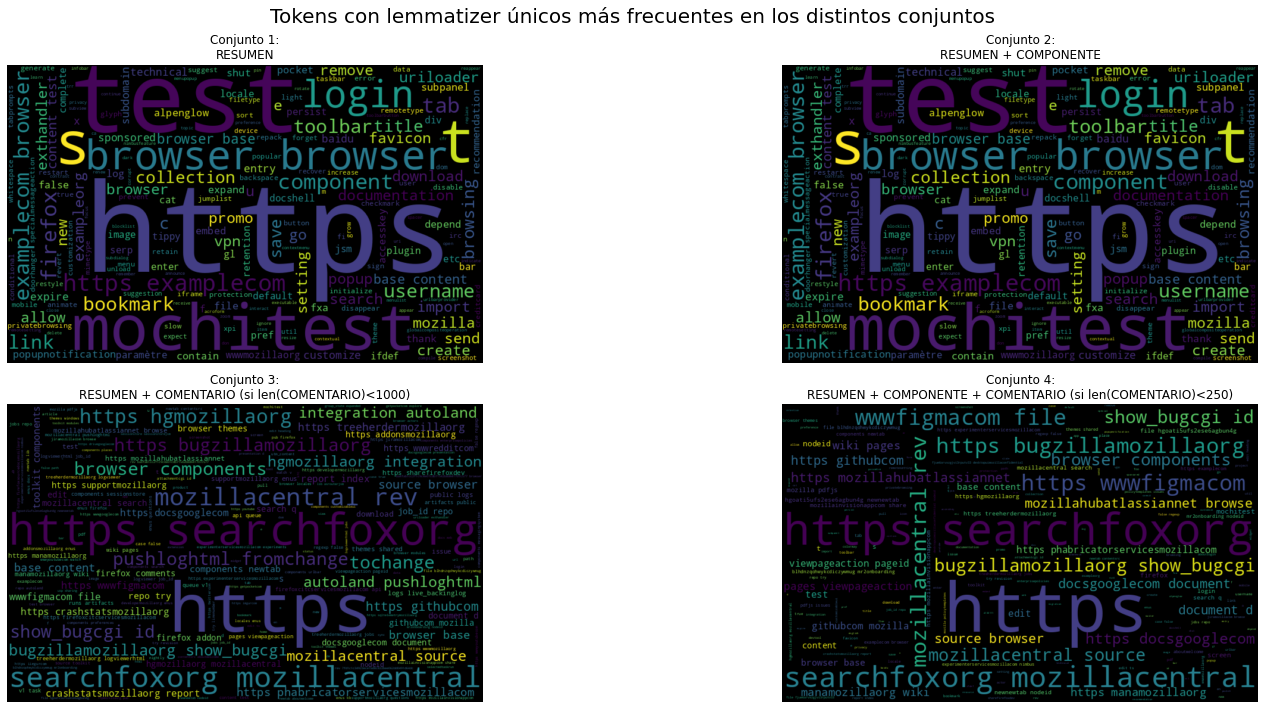

In [16]:
tokens1L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens1L))
tokens2L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens2L))
tokens3L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens3L))
tokens4L_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens4L))

fig, axs = plt.subplots(2,2, figsize=(25,10))

axs[0,0].imshow(tokens1L_wordcloud, interpolation='bilinear')
axs[0,0].set_title('Conjunto 1:\nRESUMEN')
axs[0,0].axis('off')

axs[0,1].imshow(tokens2L_wordcloud, interpolation='bilinear')
axs[0,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0,1].axis('off')

axs[1,0].imshow(tokens3L_wordcloud, interpolation='bilinear')
axs[1,0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1,0].axis('off')

axs[1,1].imshow(tokens4L_wordcloud, interpolation='bilinear')
axs[1,1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1,1].axis('off')

fig.suptitle('Tokens con lemmatizer únicos más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()


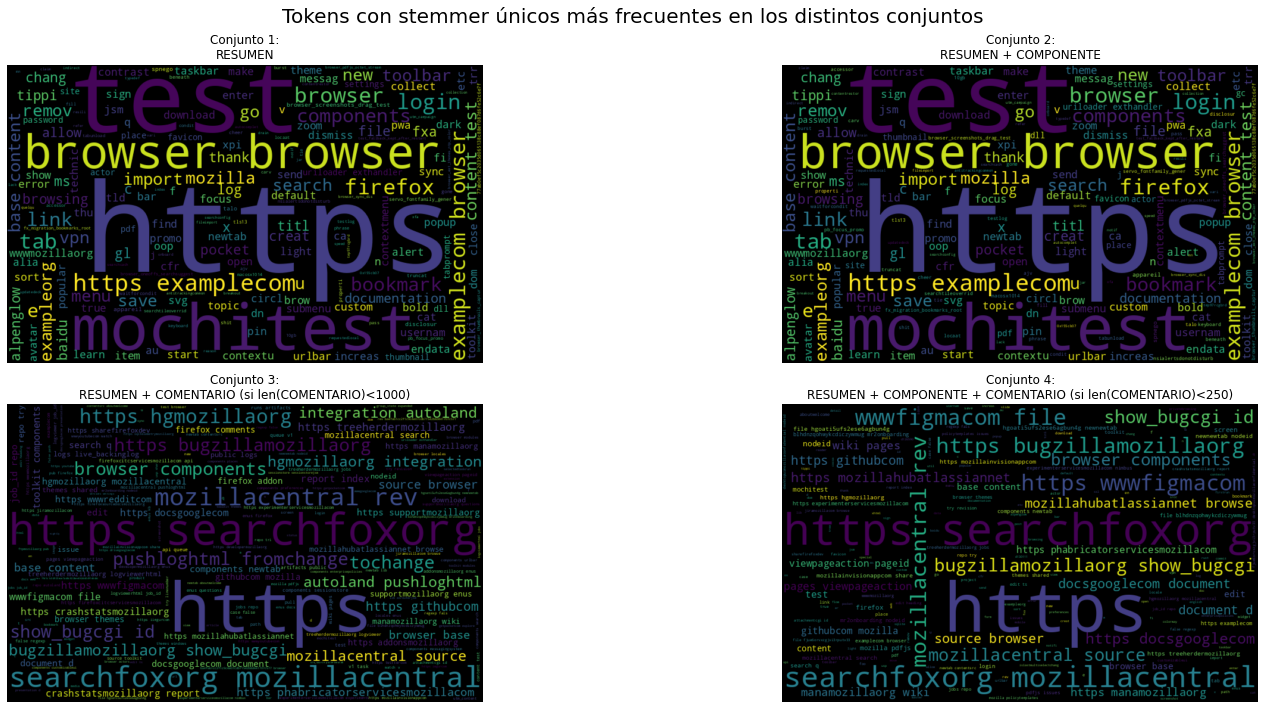

In [17]:
tokens1S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens1S))
tokens2S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens2S))
tokens3S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens3S))
tokens4S_wordcloud = WordCloud(width=800, height=500, random_state=21, max_words=200).generate(' '.join(unique_tokens4S))

fig, axs = plt.subplots(2,2, figsize=(25,10))

axs[0,0].imshow(tokens1S_wordcloud, interpolation='bilinear')
axs[0,0].set_title('Conjunto 1:\nRESUMEN')
axs[0,0].axis('off')

axs[0,1].imshow(tokens2S_wordcloud, interpolation='bilinear')
axs[0,1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0,1].axis('off')

axs[1,0].imshow(tokens3S_wordcloud, interpolation='bilinear')
axs[1,0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1,0].axis('off')

axs[1,1].imshow(tokens4S_wordcloud, interpolation='bilinear')
axs[1,1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1,1].axis('off')

fig.suptitle('Tokens con stemmer únicos más frecuentes en los distintos conjuntos', fontsize=20)
fig.tight_layout()
plt.show()


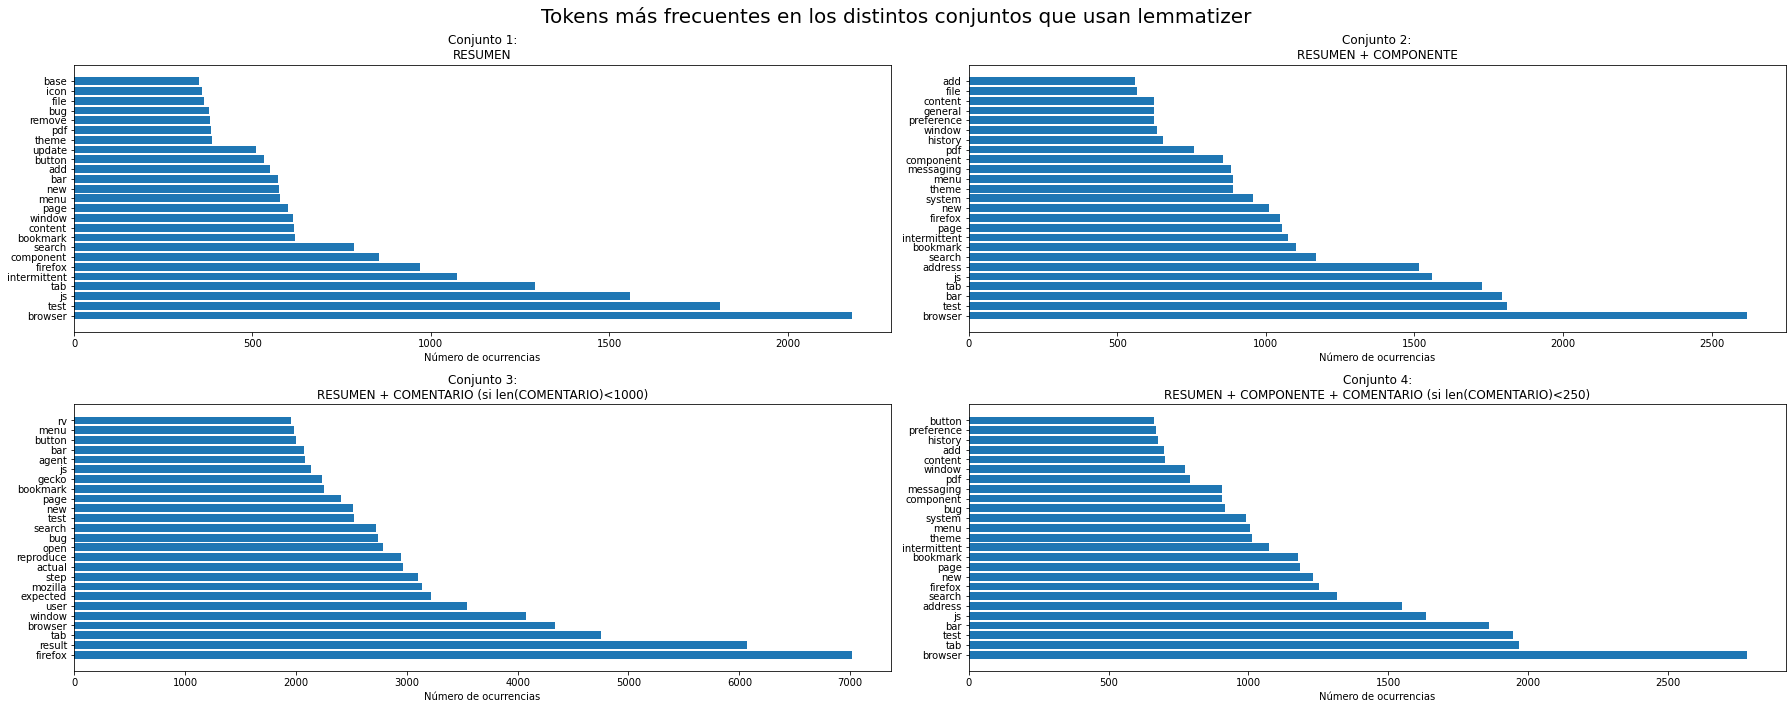

In [18]:
tokens1L_counter = Counter(word for tokens in df_reports['tokens1L'] for word in tokens)
tokens2L_counter = Counter(word for tokens in df_reports['tokens2L'] for word in tokens)
tokens3L_counter = Counter(word for tokens in df_reports['tokens3L'] for word in tokens)
tokens4L_counter = Counter(word for tokens in df_reports['tokens4L'] for word in tokens)

tokens1L_counter_25 = tokens1L_counter.most_common(25)
tokens2L_counter_25 = tokens2L_counter.most_common(25)
tokens3L_counter_25 = tokens3L_counter.most_common(25)
tokens4L_counter_25 = tokens4L_counter.most_common(25)

fig, axs = plt.subplots(2, 2, figsize=(25, 10))

axs[0, 0].barh(range(len(tokens1L_counter_25)), [count for word, count in tokens1L_counter_25], align='center')
axs[0, 0].set_yticks(range(len(tokens1L_counter_25)))
axs[0, 0].set_yticklabels([word for word, count in tokens1L_counter_25])
axs[0, 0].set_title('Conjunto 1:\nRESUMEN')
axs[0, 0].set_xlabel('Número de ocurrencias')

axs[0, 1].barh(range(len(tokens2L_counter_25)), [count for word, count in tokens2L_counter_25], align='center')
axs[0, 1].set_yticks(range(len(tokens2L_counter_25)))
axs[0, 1].set_yticklabels([word for word, count in tokens2L_counter_25])
axs[0, 1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0, 1].set_xlabel('Número de ocurrencias')

axs[1, 0].barh(range(len(tokens3L_counter_25)), [count for word, count in tokens3L_counter_25], align='center')
axs[1, 0].set_yticks(range(len(tokens3L_counter_25)))
axs[1, 0].set_yticklabels([word for word, count in tokens3L_counter_25])
axs[1, 0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1, 0].set_xlabel('Número de ocurrencias')

axs[1, 1].barh(range(len(tokens4L_counter_25)), [count for word, count in tokens4L_counter_25], align='center')
axs[1, 1].set_yticks(range(len(tokens4L_counter_25)))
axs[1, 1].set_yticklabels([word for word, count in tokens4L_counter_25])
axs[1, 1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1, 1].set_xlabel('Número de ocurrencias')

fig.suptitle('Tokens más frecuentes en los distintos conjuntos que usan lemmatizer', fontsize=20)
fig.tight_layout()
plt.show()

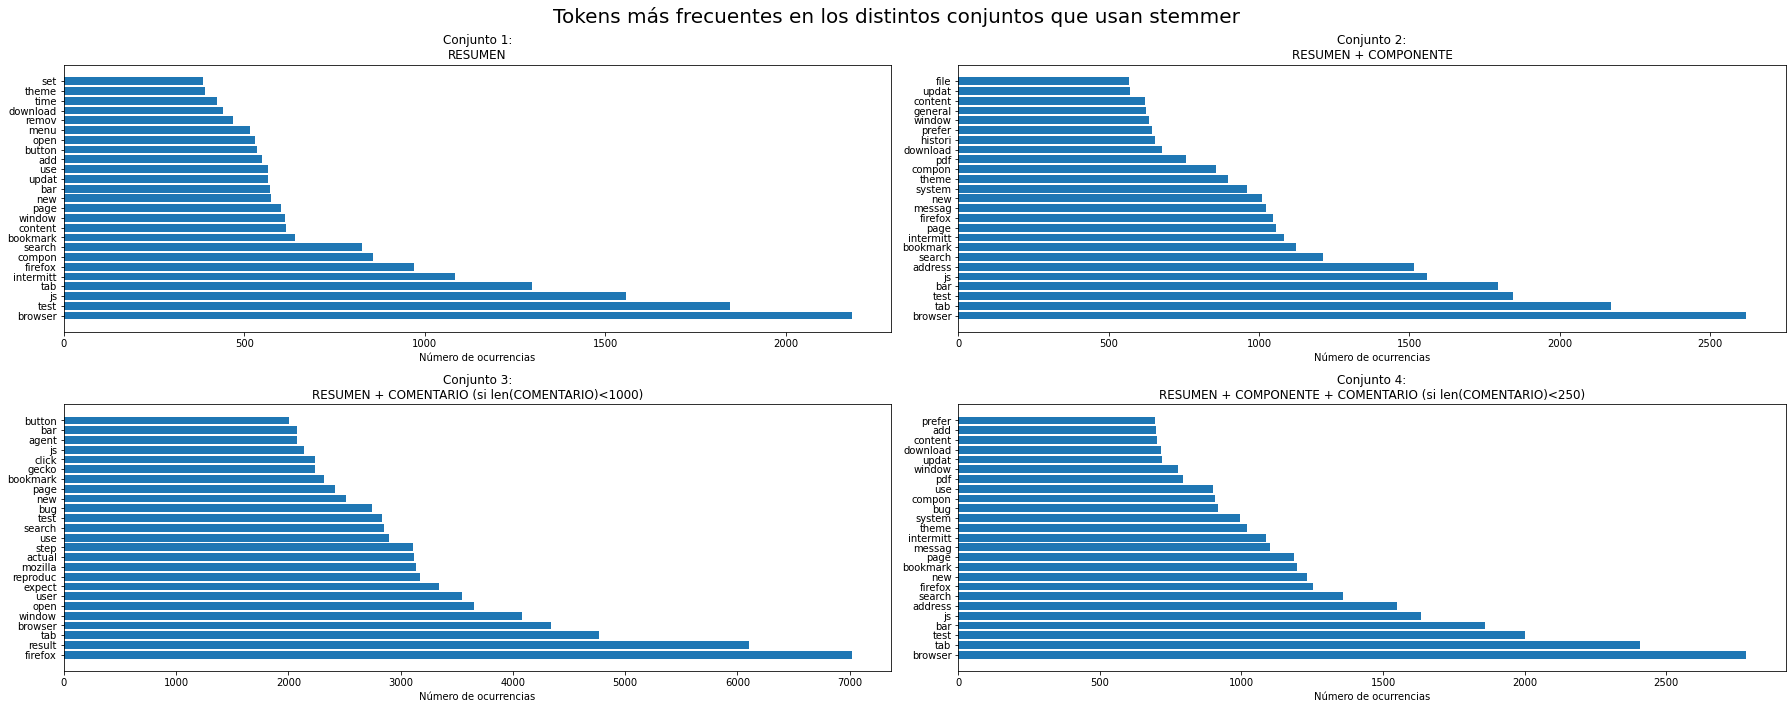

In [19]:
tokens1S_counter = Counter(word for tokens in df_reports['tokens1S'] for word in tokens)
tokens2S_counter = Counter(word for tokens in df_reports['tokens2S'] for word in tokens)
tokens3S_counter = Counter(word for tokens in df_reports['tokens3S'] for word in tokens)
tokens4S_counter = Counter(word for tokens in df_reports['tokens4S'] for word in tokens)

tokens1S_counter_25 = tokens1S_counter.most_common(25)
tokens2S_counter_25 = tokens2S_counter.most_common(25)
tokens3S_counter_25 = tokens3S_counter.most_common(25)
tokens4S_counter_25 = tokens4S_counter.most_common(25)

fig, axs = plt.subplots(2, 2, figsize=(25, 10))

axs[0, 0].barh(range(len(tokens1S_counter_25)), [count for word, count in tokens1S_counter_25], align='center')
axs[0, 0].set_yticks(range(len(tokens1S_counter_25)))
axs[0, 0].set_yticklabels([word for word, count in tokens1S_counter_25])
axs[0, 0].set_title('Conjunto 1:\nRESUMEN')
axs[0, 0].set_xlabel('Número de ocurrencias')

axs[0, 1].barh(range(len(tokens2S_counter_25)), [count for word, count in tokens2S_counter_25], align='center')
axs[0, 1].set_yticks(range(len(tokens2S_counter_25)))
axs[0, 1].set_yticklabels([word for word, count in tokens2S_counter_25])
axs[0, 1].set_title('Conjunto 2:\nRESUMEN + COMPONENTE')
axs[0, 1].set_xlabel('Número de ocurrencias')

axs[1, 0].barh(range(len(tokens3S_counter_25)), [count for word, count in tokens3S_counter_25], align='center')
axs[1, 0].set_yticks(range(len(tokens3S_counter_25)))
axs[1, 0].set_yticklabels([word for word, count in tokens3S_counter_25])
axs[1, 0].set_title('Conjunto 3:\nRESUMEN + COMENTARIO (si len(COMENTARIO)<1000)')
axs[1, 0].set_xlabel('Número de ocurrencias')

axs[1, 1].barh(range(len(tokens4S_counter_25)), [count for word, count in tokens4S_counter_25], align='center')
axs[1, 1].set_yticks(range(len(tokens4S_counter_25)))
axs[1, 1].set_yticklabels([word for word, count in tokens4S_counter_25])
axs[1, 1].set_title('Conjunto 4:\nRESUMEN + COMPONENTE + COMENTARIO (si len(COMENTARIO)<250)')
axs[1, 1].set_xlabel('Número de ocurrencias')

fig.suptitle('Tokens más frecuentes en los distintos conjuntos que usan stemmer', fontsize=20)
fig.tight_layout()
plt.show()

## Por parejas

In [20]:
df_duplicate_pairs = df_report_pairs[df_report_pairs.type == 'duplicate']

In [21]:
import warnings
warnings.filterwarnings('ignore')

df_duplicate_pairs['tokens1ML'] = df_duplicate_pairs['text1M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens1DL'] = df_duplicate_pairs['text1D'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens2ML'] = df_duplicate_pairs['text2M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens2DL'] = df_duplicate_pairs['text2D'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens3ML'] = df_duplicate_pairs['text3M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens3DL'] = df_duplicate_pairs['text3D'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens4ML'] = df_duplicate_pairs['text4M'].apply(preprocess_with_lemmatizer)
df_duplicate_pairs['tokens4DL'] = df_duplicate_pairs['text4D'].apply(preprocess_with_lemmatizer)

df_duplicate_pairs['unique_tokens1ML'] = df_duplicate_pairs['tokens1ML'].apply(set)
df_duplicate_pairs['unique_tokens1DL'] = df_duplicate_pairs['tokens1DL'].apply(set)
df_duplicate_pairs['unique_tokens2ML'] = df_duplicate_pairs['tokens2ML'].apply(set)
df_duplicate_pairs['unique_tokens2DL'] = df_duplicate_pairs['tokens2DL'].apply(set)
df_duplicate_pairs['unique_tokens3ML'] = df_duplicate_pairs['tokens3ML'].apply(set)
df_duplicate_pairs['unique_tokens3DL'] = df_duplicate_pairs['tokens3DL'].apply(set)
df_duplicate_pairs['unique_tokens4ML'] = df_duplicate_pairs['tokens4ML'].apply(set)
df_duplicate_pairs['unique_tokens4DL'] = df_duplicate_pairs['tokens4DL'].apply(set)

df_duplicate_pairs['unique_tokens_len1ML'] = df_duplicate_pairs['unique_tokens1ML'].apply(len)
df_duplicate_pairs['unique_tokens_len1DL'] = df_duplicate_pairs['unique_tokens1DL'].apply(len)
df_duplicate_pairs['unique_tokens_len2ML'] = df_duplicate_pairs['unique_tokens2ML'].apply(len)
df_duplicate_pairs['unique_tokens_len2DL'] = df_duplicate_pairs['unique_tokens2DL'].apply(len)
df_duplicate_pairs['unique_tokens_len3ML'] = df_duplicate_pairs['unique_tokens3ML'].apply(len)
df_duplicate_pairs['unique_tokens_len3DL'] = df_duplicate_pairs['unique_tokens3DL'].apply(len)
df_duplicate_pairs['unique_tokens_len4ML'] = df_duplicate_pairs['unique_tokens4ML'].apply(len)
df_duplicate_pairs['unique_tokens_len4DL'] = df_duplicate_pairs['unique_tokens4DL'].apply(len)

df_duplicate_pairs['common_tokens1L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens1ML'] & row['unique_tokens1DL'], axis=1)
df_duplicate_pairs['common_tokens2L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens2ML'] & row['unique_tokens2DL'], axis=1)
df_duplicate_pairs['common_tokens3L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens3ML'] & row['unique_tokens3DL'], axis=1)
df_duplicate_pairs['common_tokens4L'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens4ML'] & row['unique_tokens4DL'], axis=1)

df_duplicate_pairs['common_tokens_len1L'] = df_duplicate_pairs['common_tokens1L'].apply(len)
df_duplicate_pairs['common_tokens_len2L'] = df_duplicate_pairs['common_tokens2L'].apply(len)
df_duplicate_pairs['common_tokens_len3L'] = df_duplicate_pairs['common_tokens3L'].apply(len)
df_duplicate_pairs['common_tokens_len4L'] = df_duplicate_pairs['common_tokens4L'].apply(len)

In [22]:
df_duplicate_pairs['tokens1MS'] = df_duplicate_pairs['text1M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens1DS'] = df_duplicate_pairs['text1D'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens2MS'] = df_duplicate_pairs['text2M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens2DS'] = df_duplicate_pairs['text2D'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens3MS'] = df_duplicate_pairs['text3M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens3DS'] = df_duplicate_pairs['text3D'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens4MS'] = df_duplicate_pairs['text4M'].apply(preprocess_with_stemmer)
df_duplicate_pairs['tokens4DS'] = df_duplicate_pairs['text4D'].apply(preprocess_with_stemmer)

df_duplicate_pairs['unique_tokens1MS'] = df_duplicate_pairs['tokens1MS'].apply(set)
df_duplicate_pairs['unique_tokens1DS'] = df_duplicate_pairs['tokens1DS'].apply(set)
df_duplicate_pairs['unique_tokens2MS'] = df_duplicate_pairs['tokens2MS'].apply(set)
df_duplicate_pairs['unique_tokens2DS'] = df_duplicate_pairs['tokens2DS'].apply(set)
df_duplicate_pairs['unique_tokens3MS'] = df_duplicate_pairs['tokens3MS'].apply(set)
df_duplicate_pairs['unique_tokens3DS'] = df_duplicate_pairs['tokens3DS'].apply(set)
df_duplicate_pairs['unique_tokens4MS'] = df_duplicate_pairs['tokens4MS'].apply(set)
df_duplicate_pairs['unique_tokens4DS'] = df_duplicate_pairs['tokens4DS'].apply(set)

df_duplicate_pairs['unique_tokens_len1MS'] = df_duplicate_pairs['unique_tokens1MS'].apply(len)
df_duplicate_pairs['unique_tokens_len1DS'] = df_duplicate_pairs['unique_tokens1DS'].apply(len)
df_duplicate_pairs['unique_tokens_len2MS'] = df_duplicate_pairs['unique_tokens2MS'].apply(len)
df_duplicate_pairs['unique_tokens_len2DS'] = df_duplicate_pairs['unique_tokens2DS'].apply(len)
df_duplicate_pairs['unique_tokens_len3MS'] = df_duplicate_pairs['unique_tokens3MS'].apply(len)
df_duplicate_pairs['unique_tokens_len3DS'] = df_duplicate_pairs['unique_tokens3DS'].apply(len)
df_duplicate_pairs['unique_tokens_len4MS'] = df_duplicate_pairs['unique_tokens4MS'].apply(len)
df_duplicate_pairs['unique_tokens_len4DS'] = df_duplicate_pairs['unique_tokens4DS'].apply(len)

df_duplicate_pairs['common_tokens1S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens1MS'] & row['unique_tokens1DS'], axis=1)
df_duplicate_pairs['common_tokens2S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens2MS'] & row['unique_tokens2DS'], axis=1)
df_duplicate_pairs['common_tokens3S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens3MS'] & row['unique_tokens3DS'], axis=1)
df_duplicate_pairs['common_tokens4S'] = df_duplicate_pairs.apply(lambda row: row['unique_tokens4MS'] & row['unique_tokens4DS'], axis=1)

df_duplicate_pairs['common_tokens_len1S'] = df_duplicate_pairs['common_tokens1S'].apply(len)
df_duplicate_pairs['common_tokens_len2S'] = df_duplicate_pairs['common_tokens2S'].apply(len)
df_duplicate_pairs['common_tokens_len3S'] = df_duplicate_pairs['common_tokens3S'].apply(len)
df_duplicate_pairs['common_tokens_len4S'] = df_duplicate_pairs['common_tokens4S'].apply(len)

In [23]:
df_duplicate_pairs[[
    'unique_tokens_len1ML','unique_tokens_len1DL','unique_tokens_len2ML','unique_tokens_len2DL',
    'unique_tokens_len3ML','unique_tokens_len3DL','unique_tokens_len4ML','unique_tokens_len4DL'
]].describe()

,unique_tokens_len1ML,unique_tokens_len1DL,unique_tokens_len2ML,unique_tokens_len2DL,unique_tokens_len3ML,unique_tokens_len3DL,unique_tokens_len4ML,unique_tokens_len4DL
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.040000,9.023000,10.367000,10.20100,26.237000,29.478000,11.119000,10.768000
std,3.529994,4.663284,3.568339,4.79579,18.849407,18.530648,4.201249,5.193761
min,2.000000,1.000000,3.000000,2.00000,2.000000,2.000000,3.000000,2.000000
25%,7.000000,6.000000,8.000000,7.00000,10.000000,13.000000,8.000000,7.000000
50%,9.000000,8.000000,10.000000,9.00000,18.000000,27.000000,11.000000,10.000000
75%,11.000000,11.000000,12.000000,12.00000,43.000000,44.000000,12.000000,13.000000
max,28.000000,30.000000,30.000000,31.00000,79.000000,81.000000,30.000000,31.000000


In [24]:
df_duplicate_pairs[[
    'unique_tokens_len1MS','unique_tokens_len1DS','unique_tokens_len2MS','unique_tokens_len2DS',
    'unique_tokens_len3MS','unique_tokens_len3DS','unique_tokens_len4MS','unique_tokens_len4DS'
]].describe()

,unique_tokens_len1MS,unique_tokens_len1DS,unique_tokens_len2MS,unique_tokens_len2DS,unique_tokens_len3MS,unique_tokens_len3DS,unique_tokens_len4MS,unique_tokens_len4DS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,8.991000,8.966000,10.240000,10.050000,25.431000,28.599000,10.965000,10.593000
std,3.511873,4.637062,3.555424,4.781251,17.870383,17.726998,4.126112,5.132026
min,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,3.000000,2.000000
25%,7.000000,6.000000,8.000000,7.000000,10.000000,13.000000,8.000000,7.000000
50%,9.000000,8.000000,10.000000,9.000000,18.000000,26.000000,11.000000,9.000000
75%,11.000000,11.000000,12.000000,12.000000,41.250000,42.000000,12.000000,13.000000
max,28.000000,30.000000,30.000000,31.000000,78.000000,81.000000,30.000000,31.000000


In [25]:
df_duplicate_pairs[[
    'common_tokens_len1L','common_tokens_len2L','common_tokens_len3L','common_tokens_len4L'
]].describe()

,common_tokens_len1L,common_tokens_len2L,common_tokens_len3L,common_tokens_len4L
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.775000,4.695000,9.203000,4.777000
std,3.289559,3.520848,8.116629,3.540029
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,4.000000,2.000000
50%,3.000000,3.000000,7.000000,4.000000
75%,7.000000,8.000000,12.000000,8.000000
max,22.000000,22.000000,53.000000,22.000000


In [26]:
df_duplicate_pairs[[
    'common_tokens_len1S','common_tokens_len2S','common_tokens_len3S','common_tokens_len4S'
]].describe()

,common_tokens_len1S,common_tokens_len2S,common_tokens_len3S,common_tokens_len4S
count,1000.000000,1000.000000,1000.000000,1000.00000
mean,3.930000,4.785000,9.356000,4.86700
std,3.194574,3.426736,8.012582,3.44662
min,0.000000,0.000000,0.000000,0.00000
25%,1.000000,2.000000,4.000000,2.00000
50%,3.000000,4.000000,7.000000,4.00000
75%,7.000000,8.000000,12.000000,8.00000
max,22.000000,22.000000,52.000000,22.00000


In [27]:
TOP_TOKENS = 25
def get_TOP_most_frequent_common_tokens(df, column):
    rank = {}
    for i, row in df.iterrows():
        for t in row[column]:
            if t in rank:
                rank[t] +=1
            else:
                rank[t] = 1
    return sorted(rank.items(), key=lambda x: x[1], reverse=True)[:TOP_TOKENS]

rank_1L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens1L')
rank_2L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens2L')
rank_3L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens3L')
rank_4L = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens4L')
rank_1S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens1S')
rank_2S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens2S')
rank_3S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens3S')
rank_4S = get_TOP_most_frequent_common_tokens(df_duplicate_pairs, 'common_tokens4S')

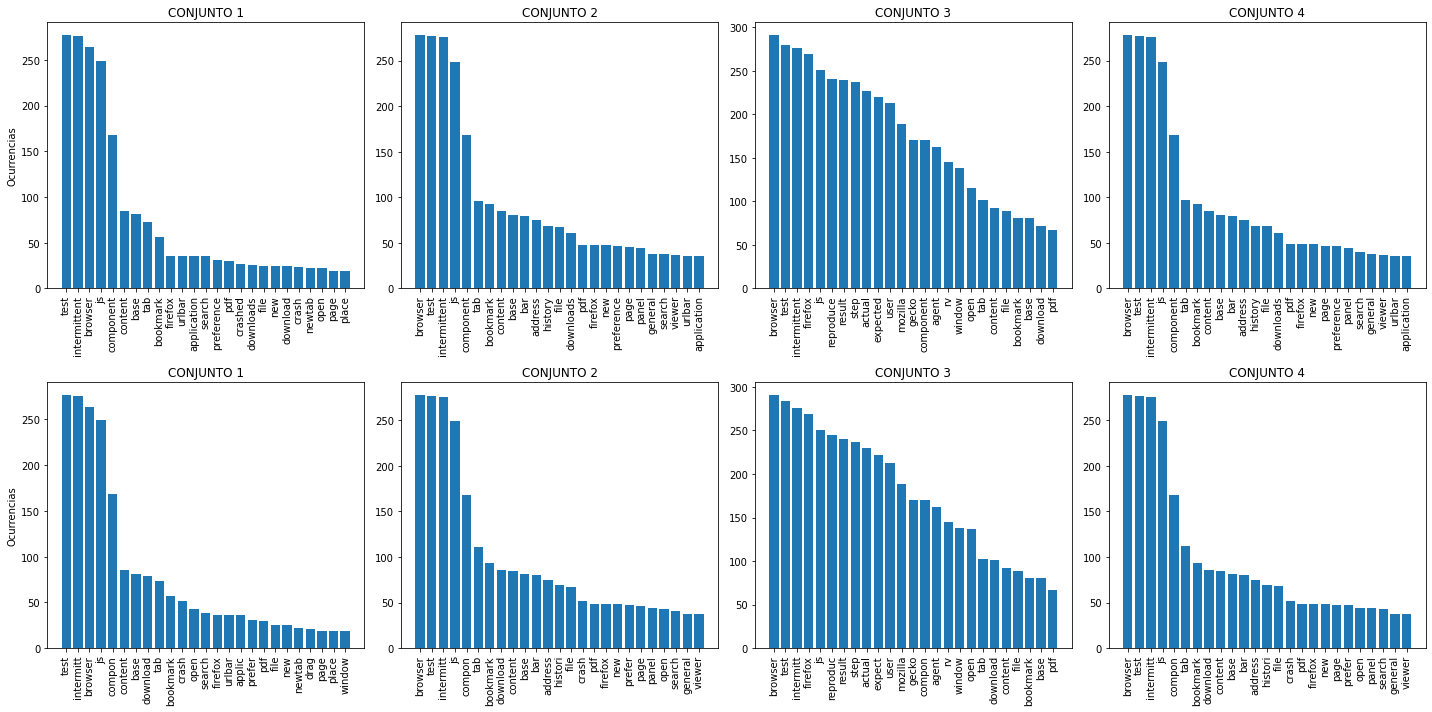

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))

# fig.set_title("Tokens compartidos entre Maestro y Duplicado más comunes")

axs[0,0].bar(range(len(rank_1L)), [x[1] for x in rank_1L], align='center')
axs[0,0].set_xticks(range(len(rank_1L)), [x[0] for x in rank_1L], rotation=90)
axs[0,0].set_ylabel('Ocurrencias')
axs[0,0].set_title('CONJUNTO 1')

axs[1,0].bar(range(len(rank_1S)), [x[1] for x in rank_1S], align='center')
axs[1,0].set_xticks(range(len(rank_1S)), [x[0] for x in rank_1S], rotation=90)
axs[1,0].set_ylabel('Ocurrencias')
axs[1,0].set_title('CONJUNTO 1')

axs[0,1].bar(range(len(rank_2L)), [x[1] for x in rank_2L], align='center')
axs[0,1].set_xticks(range(len(rank_2L)), [x[0] for x in rank_2L], rotation=90)
axs[0,1].set_title('CONJUNTO 2')

axs[1,1].bar(range(len(rank_2S)), [x[1] for x in rank_2S], align='center')
axs[1,1].set_xticks(range(len(rank_2S)), [x[0] for x in rank_2S], rotation=90)
axs[1,1].set_title('CONJUNTO 2')

axs[0,2].bar(range(len(rank_3L)), [x[1] for x in rank_3L], align='center')
axs[0,2].set_xticks(range(len(rank_3L)), [x[0] for x in rank_3L], rotation=90)
axs[0,2].set_title('CONJUNTO 3')

axs[1,2].bar(range(len(rank_3S)), [x[1] for x in rank_3S], align='center')
axs[1,2].set_xticks(range(len(rank_3S)), [x[0] for x in rank_3S], rotation=90)
axs[1,2].set_title('CONJUNTO 3')

axs[0,3].bar(range(len(rank_4L)), [x[1] for x in rank_4L], align='center')
axs[0,3].set_xticks(range(len(rank_4L)), [x[0] for x in rank_4L], rotation=90)
axs[0,3].set_title('CONJUNTO 4')

axs[1,3].bar(range(len(rank_4S)), [x[1] for x in rank_4S], align='center')
axs[1,3].set_xticks(range(len(rank_4S)), [x[0] for x in rank_4S], rotation=90)
axs[1,3].set_title('CONJUNTO 4')

fig.tight_layout()
plt.show()

# Añadir tokenes a dataframes

In [29]:
df_report_pairs['tokens1ML'] = df_report_pairs['text1M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens2ML'] = df_report_pairs['text2M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens3ML'] = df_report_pairs['text3M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens4ML'] = df_report_pairs['text4M'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens1MS'] = df_report_pairs['text1M'].apply(preprocess_with_stemmer)
df_report_pairs['tokens2MS'] = df_report_pairs['text2M'].apply(preprocess_with_stemmer)
df_report_pairs['tokens3MS'] = df_report_pairs['text3M'].apply(preprocess_with_stemmer)
df_report_pairs['tokens4MS'] = df_report_pairs['text4M'].apply(preprocess_with_stemmer)

df_report_pairs['tokens1DL'] = df_report_pairs['text1D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens2DL'] = df_report_pairs['text2D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens3DL'] = df_report_pairs['text3D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens4DL'] = df_report_pairs['text4D'].apply(preprocess_with_lemmatizer)
df_report_pairs['tokens1DS'] = df_report_pairs['text1D'].apply(preprocess_with_stemmer)
df_report_pairs['tokens2DS'] = df_report_pairs['text2D'].apply(preprocess_with_stemmer)
df_report_pairs['tokens3DS'] = df_report_pairs['text3D'].apply(preprocess_with_stemmer)
df_report_pairs['tokens4DS'] = df_report_pairs['text4D'].apply(preprocess_with_stemmer)

# Persistir

In [30]:
import os

if not os.path.exists('data'):
    os.makedirs('data')

df_reports.to_pickle('data/preprocessed_reports.pkl')
df_report_pairs[[
    'type', 'id_M', 'id_D', 'statusM', 'statusD',  'componentM', 'componentD',
    'summaryM', 'summaryD', 'commentsM',  'commentsD',
    'text1M', 'text1D', 'text2M', 'text2D', 'text3M', 'text3D', 'text4M', 'text4D',
    'tokens1ML', 'tokens2ML', 'tokens3ML', 'tokens4ML', 'tokens1DL', 'tokens2DL', 'tokens3DL', 'tokens4DL',
    'tokens1MS', 'tokens2MS', 'tokens3MS', 'tokens4MS', 'tokens1DS', 'tokens2DS', 'tokens3DS', 'tokens4DS'
]].to_pickle('data/preprocessed_report_pairs.pkl')